---
title: "seasonal decomposition from scratch"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

We will work together, running each cell in this Notebook step by step. Start by downloading the notebook ("Code" button above), and also download these 2 `csv` files:

* <a href="sst_world.csv" download>sst_daily_world.csv</a>
* <a href="sst_north.csv" download>sst_daily_north.csv</a>

## sea surface temperature

In [1]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime as dt
import time
from statsmodels.tsa.stattools import adfuller

# %matplotlib widget

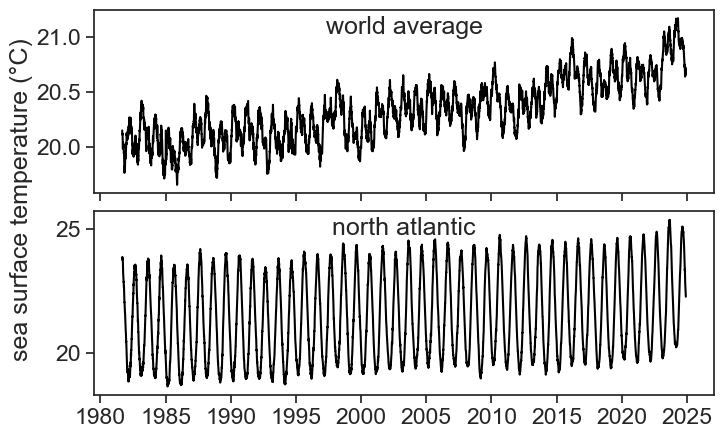

In [3]:
#| code-summary: "load and plot data"
df_north = pd.read_csv("sst_north.csv", index_col='date', parse_dates=True)
df_world = pd.read_csv("sst_world.csv", index_col='date', parse_dates=True)

fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)
fig.subplots_adjust(hspace=0.1)  # increase vertical space between panels
ax[0].plot(df_world['sst'], color="black")
ax[1].plot(df_north['sst'], color="black")
fig.text(0.02, 0.5, 'sea surface temperature (°C)', va='center', rotation='vertical')
ax[1].set(yticks=[20, 25])
ax[0].text(0.5, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='center', verticalalignment='top',)
ax[1].text(0.5, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='center', verticalalignment='top',)
pass

## trend

Take a rolling average of the data, using a 365-day window. Do it twice, one using `'365D'` and another using `365`. What's the difference?

In [30]:
#| code-fold: false
df_north['trend'] = df_north['sst'].rolling(365, center=True).mean()
df_north['trend2'] = df_north['sst'].rolling('365D', center=True).mean()
df_world['trend'] = df_world['sst'].rolling(365, center=True).mean()
df_world['trend2'] = df_world['sst'].rolling('365D', center=True).mean()

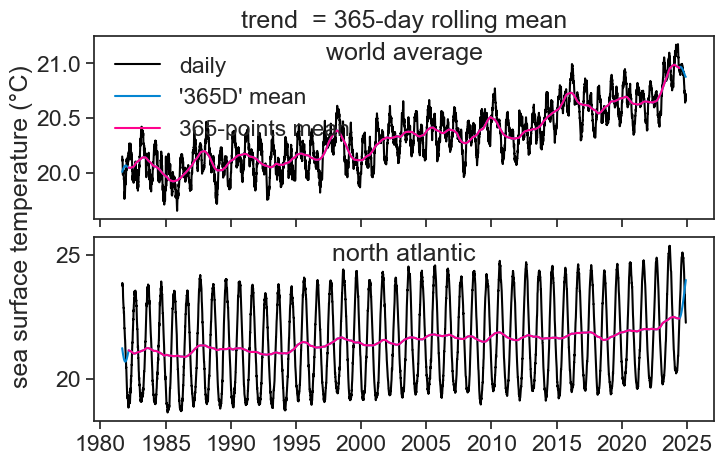

In [39]:
#| code-summary: "plot trend"
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)
fig.subplots_adjust(hspace=0.1)  # increase vertical space between panels
ax[0].plot(df_world['sst'], color="black", label="daily")
ax[0].plot(df_world['trend2'], color="xkcd:cerulean", label="'365D' mean")
ax[0].plot(df_world['trend'], color="xkcd:hot pink", label="365-points mean")
ax[1].plot(df_north['sst'], color="black")
ax[1].plot(df_north['trend2'], color="xkcd:cerulean")
ax[1].plot(df_north['trend'], color="xkcd:hot pink")
fig.text(0.02, 0.5, 'sea surface temperature (°C)', va='center', rotation='vertical')
ax[0].set(title="trend  = 365-day rolling mean")
ax[1].set(yticks=[20, 25])
ax[0].text(0.5, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='center', verticalalignment='top',)
ax[1].text(0.5, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='center', verticalalignment='top',)
ax[0].legend(frameon=False)
pass

## detrend

$$
\text{detrended} = \text{signal} - \text{trend}
$$

In [40]:
#| code-fold: false
df_north['detrended'] = df_north['sst'] - df_north['trend']
df_world['detrended'] = df_world['sst'] - df_world['trend']

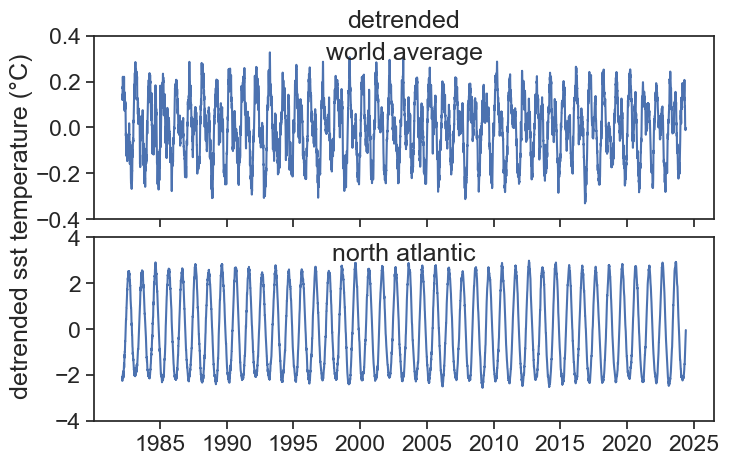

In [41]:
#| code-summary: "plot trend"
fig, ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)
fig.subplots_adjust(hspace=0.1)  # increase vertical space between panels
ax[0].plot(df_world['detrended'])
ax[1].plot(df_north['detrended'])
fig.text(0.02, 0.5, 'detrended sst temperature (°C)', va='center', rotation='vertical')
ax[0].set(ylim=[-0.4,0.4],
          title="detrended")
ax[1].set(ylim=[-4,4],)
ax[0].text(0.5, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='center', verticalalignment='top',)
ax[1].text(0.5, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='center', verticalalignment='top',)
pass

## seasonal component

It is useful to add two new columns to our dataframes: `doy` (day of year) and `year`:

In [42]:
#| code-fold: false
df_north['doy'] = df_north.index.day_of_year
df_north['year'] = df_north.index.year
df_world['doy'] = df_world.index.day_of_year
df_world['year'] = df_world.index.year
df_world

,sst,trend,detrended,doy,year,seasonal,resid,trend2
date,,,,,,,,
1981-09-01,20.147,NaN,NaN,244,1981,0.052405,0.087518,20.007077
1981-09-02,20.138,NaN,NaN,245,1981,0.050953,0.078981,20.008065
1981-09-03,20.133,NaN,NaN,246,1981,0.048114,0.075837,20.009049
1981-09-04,20.130,NaN,NaN,247,1981,0.046117,0.073937,20.009946
1981-09-05,20.119,NaN,NaN,248,1981,0.044121,0.064098,20.010781
...,...,...,...,...,...,...,...,...
2024-11-26,20.685,NaN,NaN,331,2024,-0.202469,0.011522,20.875947
2024-11-27,20.663,NaN,NaN,332,2024,-0.202429,-0.010109,20.875538
2024-11-28,20.657,NaN,NaN,333,2024,-0.202663,-0.015450,20.875114


### group by

This is an extremely useful method. As the name suggests, it groups data according to some criterion.

In [43]:
#| code-fold: false
gb_year_north = df_north.groupby('year')
gb_year_world = df_world.groupby('year')

Just like `resample` and `rolling`, `groupby` doesn't do anything after grouping the data, it waits for further instructions.

In [44]:
#| code-fold: false
gb_year_world['sst'].mean()

year
1981    19.953533
1982    20.051666
1983    20.133049
1984    20.029951
1985    19.923997
1986    19.994058
1987    20.148948
1988    20.107847
1989    20.039701
1990    20.152912
1991    20.145792
1992    20.069243
1993    20.080611
1994    20.098230
1995    20.170759
1996    20.118675
1997    20.269997
1998    20.328770
1999    20.117570
2000    20.151910
2001    20.286447
2002    20.321718
2003    20.371005
2004    20.328891
2005    20.412482
2006    20.374159
2007    20.321000
2008    20.313038
2009    20.432312
2010    20.436249
2011    20.314384
2012    20.369612
2013    20.404005
2014    20.525603
2015    20.647521
2016    20.671123
2017    20.607729
2018    20.567978
2019    20.652666
2020    20.678068
2021    20.630775
2022    20.648411
2023    20.889337
2024    20.965325
Name: sst, dtype: float64

If all you need is the average by years, then the most common way of writing the command would be in one single line:

```python
df_world.groupby('year')['sst'].mean()
```

Let's use `groupby` to plot world SST for all years, see how handy this method is.
Also note that groupby return an object that can be iterated upon, as we do below.

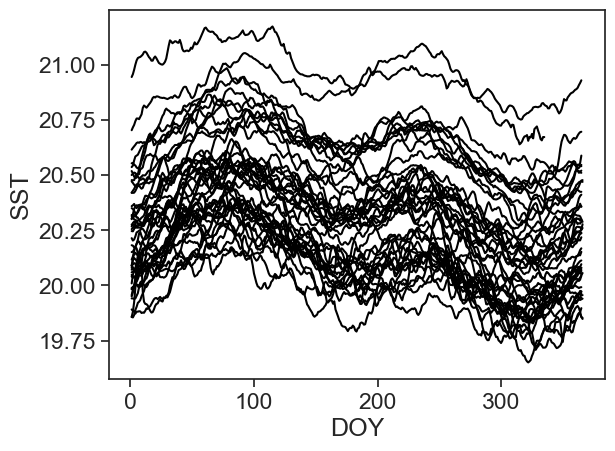

In [45]:
#| code-fold: false
fig, ax = plt.subplots()
for year, data in gb_year_world:
    ax.plot(data['doy'], data['sst'], color="black")
ax.set(xlabel="DOY", ylabel="SST");

With a few more lines of code we can make this look pretty.

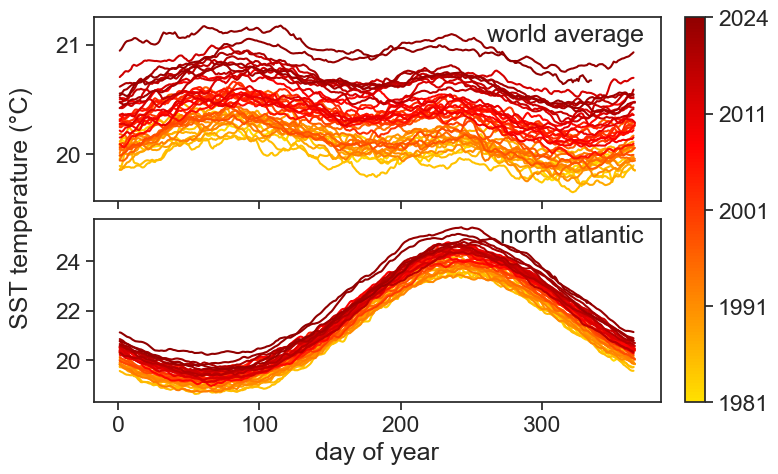

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
fig.subplots_adjust(hspace=0.1)

# define the segment of the colormap to use
start, end = 0.3, 0.8
base_cmap = plt.cm.hot_r
new_colors = base_cmap(np.linspace(start, end, 256))
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("trunc({n},{a:.2f},{b:.2f})".format(n=base_cmap.name, a=start, b=end), new_colors)
# defining the years for plotting
years = [year for year, _ in gb_year_world] + [year for year, _ in gb_year_north]
min_year, max_year = min(years), max(years)
# create a new normalization that matches the years to the new colormap
norm = mpl.colors.Normalize(vmin=min_year, vmax=max_year)
# plotting the data with year-specific colors from the new colormap
for year, data in gb_year_world:
    ax[0].plot(data.index.day_of_year, data['sst'], color=new_cmap(norm(year)))
for year, data in gb_year_north:
    ax[1].plot(data.index.day_of_year, data['sst'], color=new_cmap(norm(year)))

# colorbar setup
sm = mpl.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.046, pad=0.04)
ticks_years = [1981, 1991, 2001, 2011, 2024]  # Specify years for colorbar ticks
cbar.set_ticks(np.linspace(min_year, max_year, num=len(ticks_years)))
cbar.set_ticklabels(ticks_years)
# adding shared ylabel and xlabel
fig.text(0.02, 0.5, 'SST temperature (°C)', va='center', rotation='vertical')
ax[1].set_xlabel("day of year")
ax[0].text(0.97, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='right', verticalalignment='top',)
ax[1].text(0.97, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='right', verticalalignment='top',);

Now let's do the same for the detrended SST:

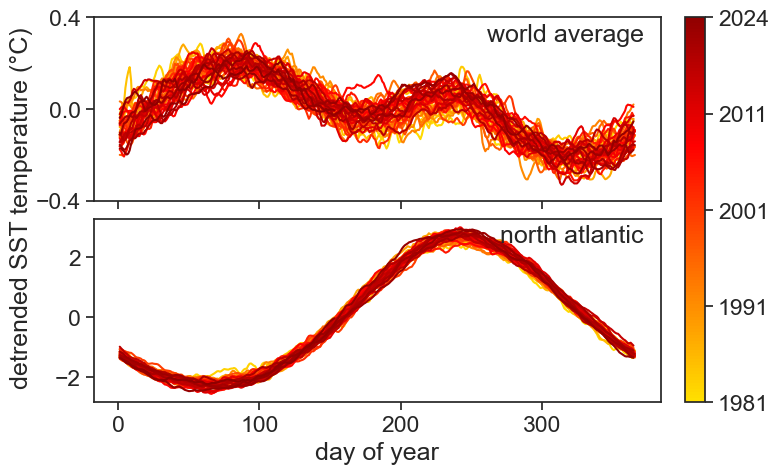

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
fig.subplots_adjust(hspace=0.1)

# define the segment of the colormap to use
start, end = 0.3, 0.8
base_cmap = plt.cm.hot_r
new_colors = base_cmap(np.linspace(start, end, 256))
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("trunc({n},{a:.2f},{b:.2f})".format(n=base_cmap.name, a=start, b=end), new_colors)
# defining the years for plotting
years = [year for year, _ in gb_year_world] + [year for year, _ in gb_year_north]
min_year, max_year = min(years), max(years)
# create a new normalization that matches the years to the new colormap
norm = mpl.colors.Normalize(vmin=min_year, vmax=max_year)
# plotting the data with year-specific colors from the new colormap
for year, data in gb_year_world:
    ax[0].plot(data.index.day_of_year, data['detrended'], color=new_cmap(norm(year)))
for year, data in gb_year_north:
    ax[1].plot(data.index.day_of_year, data['detrended'], color=new_cmap(norm(year)))
# colorbar setup
sm = mpl.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.046, pad=0.04)
ticks_years = [1981, 1991, 2001, 2011, 2024]  # Specify years for colorbar ticks
cbar.set_ticks(np.linspace(min_year, max_year, num=len(ticks_years)))
cbar.set_ticklabels(ticks_years)
# adding shared ylabel and xlabel
fig.text(0.02, 0.5, 'detrended SST temperature (°C)', va='center', rotation='vertical')
ax[0].set(yticks=[-0.4,0,0.4])
ax[1].set_xlabel("day of year")
ax[0].text(0.97, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='right', verticalalignment='top',)
ax[1].text(0.97, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='right', verticalalignment='top',);

In order to determine what is the seasonal component, we need to calculate the average of the detrended data across all years. Again, `groupby` comes to rescue in a most elegant way:

In [48]:
#| code-fold: false
avg_north = df_north.groupby('doy')['detrended'].mean()
avg_world = df_world.groupby('doy')['detrended'].mean()

Let's incorporate the averages in the same graphs we saw above:

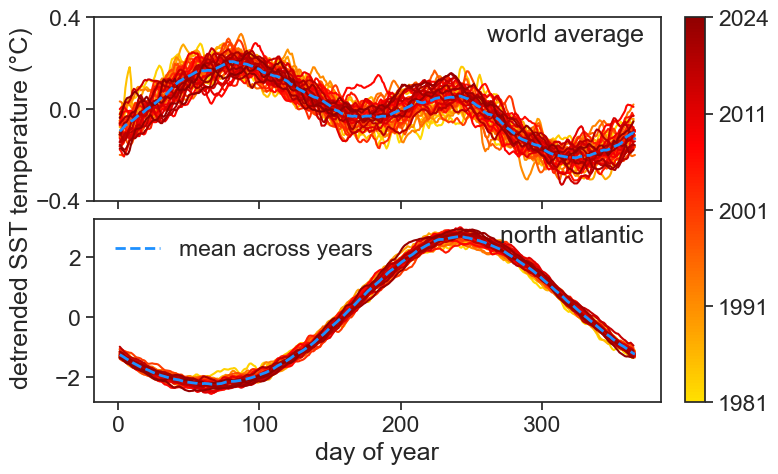

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
fig.subplots_adjust(hspace=0.1)

# define the segment of the colormap to use
start, end = 0.3, 0.8
base_cmap = plt.cm.hot_r
new_colors = base_cmap(np.linspace(start, end, 256))
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("trunc({n},{a:.2f},{b:.2f})".format(n=base_cmap.name, a=start, b=end), new_colors)
# defining the years for plotting
years = [year for year, _ in gb_year_world] + [year for year, _ in gb_year_north]
min_year, max_year = min(years), max(years)
# create a new normalization that matches the years to the new colormap
norm = mpl.colors.Normalize(vmin=min_year, vmax=max_year)
# plotting the data with year-specific colors from the new colormap
for year, data in gb_year_world:
    ax[0].plot(data.index.day_of_year, data['detrended'], color=new_cmap(norm(year)))
for year, data in gb_year_north:
    ax[1].plot(data.index.day_of_year, data['detrended'], color=new_cmap(norm(year)))

ax[0].plot(avg_world, color='dodgerblue', lw=2, ls='--')
ax[1].plot(avg_north, color='dodgerblue', lw=2, ls='--', label="mean across years")
ax[1].legend(loc="upper left", frameon=False)

# colorbar setup
sm = mpl.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical', fraction=0.046, pad=0.04)
ticks_years = [1981, 1991, 2001, 2011, 2024]  # Specify years for colorbar ticks
cbar.set_ticks(np.linspace(min_year, max_year, num=len(ticks_years)))
cbar.set_ticklabels(ticks_years)
# adding shared ylabel and xlabel
fig.text(0.02, 0.5, 'detrended SST temperature (°C)', va='center', rotation='vertical')
ax[0].set(yticks=[-0.4,0,0.4])
ax[1].set_xlabel("day of year")
ax[0].text(0.97, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='right', verticalalignment='top',)
ax[1].text(0.97, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='right', verticalalignment='top',);

In [50]:
avg_north

doy
1     -1.253732
2     -1.280922
3     -1.306364
4     -1.339380
5     -1.373020
         ...   
362   -1.123808
363   -1.156108
364   -1.187749
365   -1.216297
366   -1.234539
Name: detrended, Length: 366, dtype: float64

In [51]:
df_north

,sst,trend,detrended,doy,year,seasonal,resid,trend2
date,,,,,,,,
1981-09-01,23.783,NaN,NaN,244,1981,2.645984,-0.100159,21.237175
1981-09-02,23.774,NaN,NaN,245,1981,2.640882,-0.092012,21.225130
1981-09-03,23.795,NaN,NaN,246,1981,2.629340,-0.047437,21.213097
1981-09-04,23.831,NaN,NaN,247,1981,2.625326,0.004711,21.200962
1981-09-05,23.866,NaN,NaN,248,1981,2.619237,0.058180,21.188583
...,...,...,...,...,...,...,...,...
2024-11-26,22.399,NaN,NaN,331,2024,-0.011163,-1.546035,23.956198
2024-11-27,22.317,NaN,NaN,332,2024,-0.048139,-1.600329,23.965468
2024-11-28,22.326,NaN,NaN,333,2024,-0.088961,-1.559585,23.974546


The seasonal component is the average across all years, repeated over and over.

In [52]:
#| code-fold: false
df_north['seasonal'] = df_north['doy'].map(avg_north)
df_world['seasonal'] = df_world['doy'].map(avg_world)

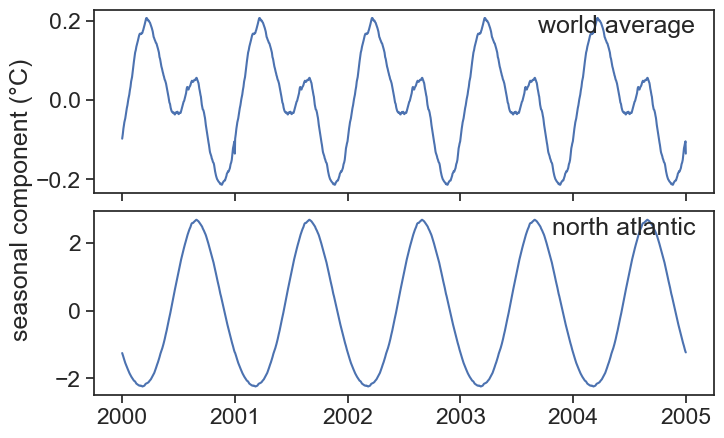

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
fig.subplots_adjust(hspace=0.1)
ax[0].plot(df_world.loc['2000':'2004', 'seasonal'])
ax[1].plot(df_north.loc['2000':'2004', 'seasonal'])
# adding shared ylabel and xlabel
fig.text(0.02, 0.5, 'seasonal component (°C)', va='center', rotation='vertical')
ax[0].text(0.97, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='right', verticalalignment='top',)
ax[1].text(0.97, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='right', verticalalignment='top',);

## residual

$$
\text{residual} = \text{signal} - \text{trend} - \text{seasonal}
$$

In [54]:
#| code-fold: false
df_world['resid'] = df_world['detrended'] - df_world['seasonal']
df_north['resid'] = df_north['detrended'] - df_north['seasonal']

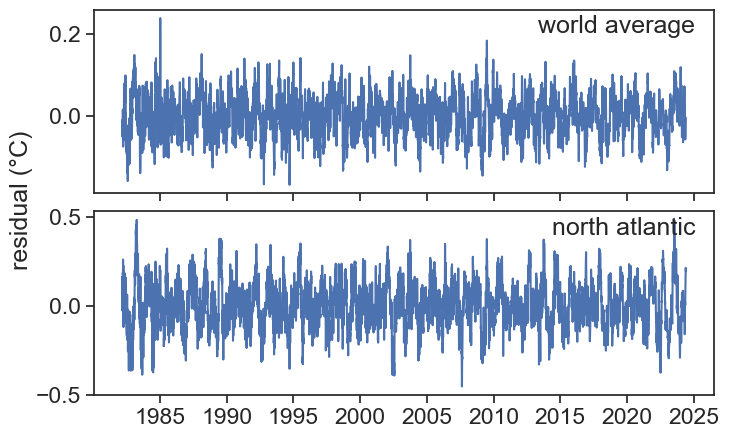

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
fig.subplots_adjust(hspace=0.1)
ax[0].plot(df_world['resid'])
ax[1].plot(df_north['resid'])
# adding shared ylabel and xlabel
fig.text(0.02, 0.5, 'residual (°C)', va='center', rotation='vertical')
ax[0].text(0.97, 0.97, r"world average", transform=ax[0].transAxes,
           horizontalalignment='right', verticalalignment='top',)
ax[1].text(0.97, 0.97, r"north atlantic", transform=ax[1].transAxes,
           horizontalalignment='right', verticalalignment='top',);

How do we know we have properly decomposed our signal into `trend`, `seasonal` and `residual`? The residual should be stationary. Let's check using the ADF test:

In [58]:
result = adfuller(df_world['resid'].dropna())
print('World-average residual\nADF test p-value: ', result[1])

result = adfuller(df_north['resid'].dropna())
print('North-Atlantic residual\nADF test p-value: ', result[1])

World-average residual
ADF test p-value:  8.492905192092961e-26
North-Atlantic residual
ADF test p-value:  3.4138001038057293e-23


## seasonal decomposition

It is customary to plot each component in its own panel:

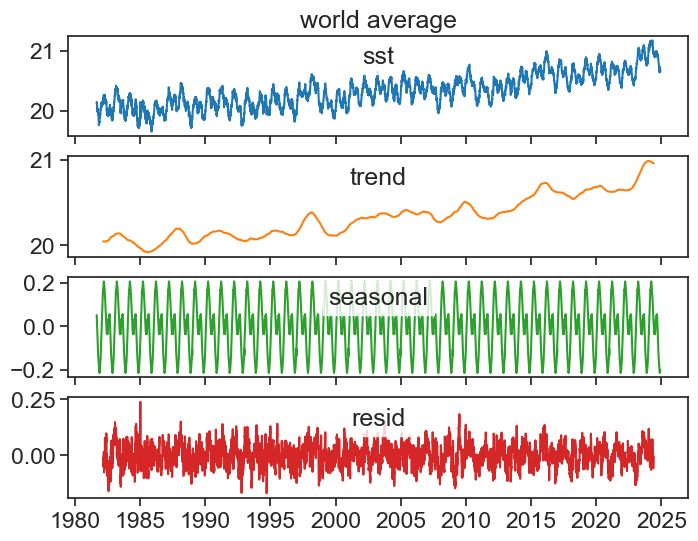

In [59]:
fig, ax = plt.subplots(4, 1, figsize=(8,6), sharex=True)
pos = (0.5, 0.9)
components =["sst", "trend", "seasonal", "resid"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for axx, component, color in zip(ax, components, colors):
    data = getattr(df_world, component)
    axx.plot(data, color=color)
    axx.text(*pos, component, bbox=dict(facecolor='white', alpha=0.8),
           transform=axx.transAxes, ha='center', va='top')
ax[0].set(title="world average");

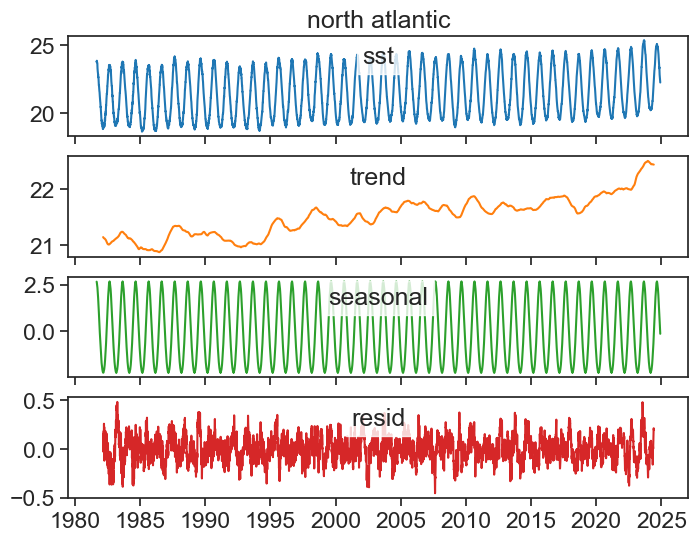

In [60]:
fig, ax = plt.subplots(4, 1, figsize=(8,6), sharex=True)
pos = (0.5, 0.9)
components =["sst", "trend", "seasonal", "resid"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for axx, component, color in zip(ax, components, colors):
    data = getattr(df_north, component)
    axx.plot(data, color=color)
    axx.text(*pos, component, bbox=dict(facecolor='white', alpha=0.8),
           transform=axx.transAxes, ha='center', va='top')
ax[0].set(title="north atlantic");

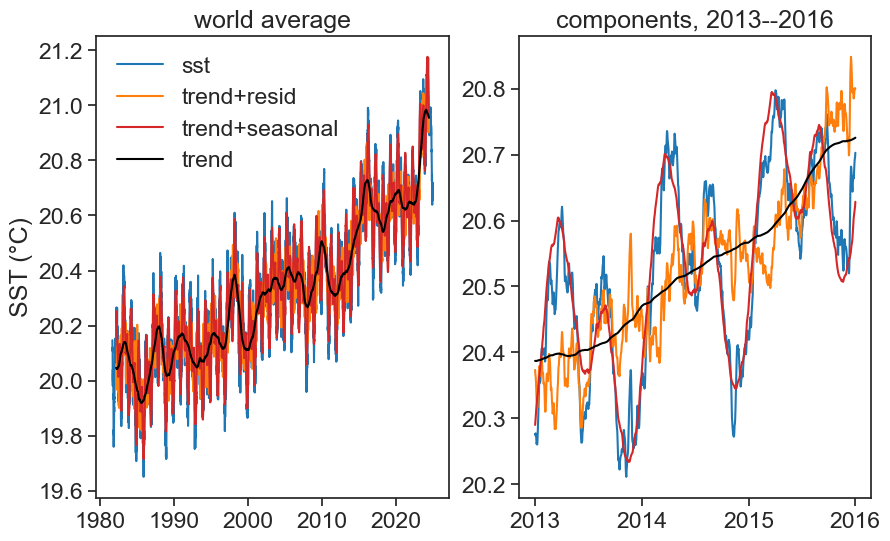

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].plot(df_world['sst'], color="tab:blue", label="sst")
ax[0].plot(df_world['trend'] + df_world['resid'], color="tab:orange", label="trend+resid")
ax[0].plot(df_world['trend'] + df_world['seasonal'], color="tab:red", label="trend+seasonal")
ax[0].plot(df_world['trend'], color="black", label="trend")
ax[0].set(ylabel="SST (°C)",
          title="world average")
date_form = DateFormatter("%Y")
ax[0].xaxis.set_major_formatter(date_form)
ax[0].xaxis.set_major_locator(mdates.YearLocator(10))
ax[0].legend(frameon=False)

start = "2013-01-01"
end = "2016-01-01"
zoom = slice(start, end)
ax[1].plot(df_world.loc[zoom, 'sst'], color="tab:blue", label="sst")
ax[1].plot(df_world.loc[zoom, 'trend'] + df_world.loc[zoom, 'resid'], color="tab:orange", label="trend+resid")
ax[1].plot(df_world.loc[zoom, 'trend'] + df_world.loc[zoom, 'seasonal'], color="tab:red", label="trend+seasonal")
ax[1].plot(df_world.loc[zoom, 'trend'], color="black", label="trend")
date_form = DateFormatter("%Y")
ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(mdates.YearLocator(1))
ax[1].set_title("components, 2013--2016");
